In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
from matplotlib.pyplot import figure

from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """


    
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    which = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1453*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k +1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_gas = gas_density[k]
                            peak_gamma = calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1452)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    for i in range(len(distance)):
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (1e16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int)
                        neutral_fraction.append(peak_fraction)
                        HI.append(peak_HI)
                        gamma.append(peak_gamma)
                        gas_den.append(peak_gas)
                        which.append([i,distance[left_bases], distance[right_bases], peak_distance])
    return real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under


In [4]:
real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under = lyman_identification()

In [5]:
for i in range(len(real_lyman)):
    if(real_lyman[i][0][-1] == 1.2103990884021668e+19):
        print(i)

2706


In [6]:
with open('color_data0_cul_integral.pkl', 'rb') as f:
    colors = pickle.load(f)
with open('color_data1_cul_integral.pkl', 'rb') as f:
    colors_1 = pickle.load(f)

In [7]:
lyman_values = []
colors_values = []
for i in colors:
    lyman_values.append(i[0][0][-1])
    colors_values.append(i[1])
for i in colors_1:
    lyman_values.append(i[0][0][-1])
    colors_values.append(i[1])


In [8]:
np.average(np.multiply(np.divide(lyman_values,HI),3.24078e-22))

2.6825873073814326

In [9]:
sigma = 6.3e-18
optical_depth = np.multiply(sigma,lyman_values)

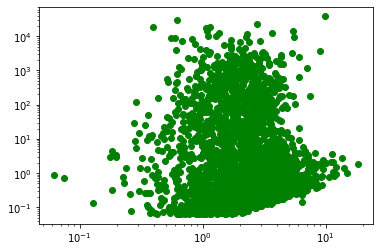

In [10]:
plt.scatter(np.multiply(np.divide(lyman_values,HI),3.24078e-22),optical_depth,c = "green")
plt.xscale("log")
plt.yscale("log")

In [11]:
list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []
list_6 = []
list_7 = []
list_8 = []
list_9 = []
list_10 = []
list_11 = []
list_12 = []
list_13 = []
list_14 = []
list_15 = []
list_16 = []
color_difference = []
def which_range_color():
    for i in (range(len(lyman_values))):
        if(colors_values[i] == 1):
            list_1.append(np.multiply(np.divide(lyman_values[i],HI[i]),3.24078e-22))
            list_2.append(neutral_fraction[i])
            list_3.append(np.multiply(gas_den[i],1.674e-24)/8.69e-28)
            list_13.append(optical_depth[i])
            color_difference.append(str("blue"))
        elif(colors_values[i] == 2):
            list_4.append(np.multiply(np.divide(lyman_values[i],HI[i]),3.24078e-22))
            list_5.append(neutral_fraction[i])
            list_6.append(np.multiply(gas_den[i],1.674e-24)/8.69e-28)
            list_14.append(optical_depth[i])
            color_difference.append(str("red"))
        elif(colors_values[i] == 3):
            list_7.append(np.multiply(np.divide(lyman_values[i],HI[i]),3.24078e-22))
            list_8.append(neutral_fraction[i])
            list_9.append(np.multiply(gas_den[i],1.674e-24)/8.69e-28)
            list_15.append(optical_depth[i])
            color_difference.append(str("orange"))
        elif(colors_values[i] == 4) :
            list_10.append(np.multiply(np.divide(lyman_values[i],HI[i]),3.24078e-22))
            list_11.append(neutral_fraction[i])
            list_12.append(np.multiply(gas_den[i],1.674e-24)/8.69e-28)
            list_16.append(optical_depth[i])
            color_difference.append(str("green"))
        elif(colors_values[i] == 5):
            color_difference.append(str("black"))

In [12]:
len(color_difference)

0

In [13]:
which_range_color()

In [14]:
# with plt.style.context('science','notebook'):
#     fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize=(6.5,10),gridspec_kw={'height_ratios': [1.25, 1,1,1,1]})
#     ax_list = ax[:,0]
#     ax_list[0].get_shared_x_axes().join(ax_list[0],*ax_list)
#     ax_list[0].set_xlim(10**(-1.5),10**1.5)
#     ax_list_2 = ax[:,1]
#     ax_list_2[0].get_shared_x_axes().join(ax_list_2[0],*ax_list_2)
#     ax_list_2[0].set_xlim(10**(-3),1)
#     ax_list_3 = ax[:,2]
#     ax_list_3[0].get_shared_x_axes().join(ax_list_3[0],*ax_list_3)
#     ax_list_3[0].set_xlim(1,1000)
#     ax[0][0].set_ylabel(r"$\tau$",fontsize = 20)
#     #first it is in cm, HI is number density
#     ax[1][0].scatter(list_1,list_13,s=.2, c = "blue")
#     ax[1][0].set_ylabel(r"$\tau$",fontsize = 20)
#     ax[1][0].annotate("$\mathrm{1 Rvir}$",fontsize = 15,xy=(10**(-1.25), 10**3.5),)
#     ax[2][0].scatter(list_4,list_14,s=.2,c = "red")
#     ax[2][0].set_ylabel(r"$\tau$",fontsize = 20)
#     ax[2][0].annotate("$\mathrm{2 Rvir}$",fontsize = 15,xy=(10**(-1.25), 10**3.5),)
#     ax[3][0].scatter(list_7,list_15,s=.2,c = "orange")
#     ax[3][0].set_ylabel(r"$\tau$",fontsize = 20)
#     ax[3][0].annotate("$\mathrm{3 Rvir}$",fontsize = 15,xy=(10**(-1.25), 10**3.5),)
#     ax[4][0].scatter(list_10,list_16,s=.2,c = "green")
#     ax[4][0].set_xlabel("$\mathrm{L_{eff}(kpc)}$",fontsize = 20)
#     ax[4][0].set_ylabel(r"$\tau$",fontsize = 20)
#     ax[4][0].annotate("$\mathrm{4 Rvir}$",fontsize = 15,xy=(10**(-1.25), 10**3.5),)
#     ax[4][1].set_xlabel("$\mathrm{X_{HI}}$",fontsize = 20)
#     ax[1][1].scatter(list_2,list_13,s=.2,c = "blue")
#     ax[2][1].scatter(list_5,list_14,s=.2,c = "red")
#     ax[3][1].scatter(list_8,list_15,s=.2,c = "orange")
#     ax[4][1].scatter(list_11,list_16,s=.2,c = "green")
#     ax[1][2].scatter(list_3,list_13,s=.2,c = "blue")
#     ax[2][2].scatter(list_6,list_14,s=.2,c = "red")
#     ax[3][2].scatter(list_9,list_15,s=.2,c = "orange")
#     ax[4][2].scatter(list_12,list_16,s=.2,c = "green")
#     ax[4][2].set_xlabel("$\mathrm{1+\delta}$",fontsize = 20)
#     ax[4][0].set_ylabel(r"$\tau$",fontsize = 20)
#     data = ax[0][0].hexbin(np.multiply(np.divide(lyman_values,HI),3.24078e-22),optical_depth,gridsize=50,bins='log',mincnt=1,xscale="log",yscale="log",cmap ='CMRmap')
#     cb1 = plt.colorbar(data,location = "top",pad = 0.01,ax = ax[0][0])
#     cb1.ax.tick_params(labelsize=13)
#     data2 = ax[0][1].hexbin(neutral_fraction,optical_depth,gridsize=50,bins='log',mincnt=1,xscale="log",yscale="log",cmap ='CMRmap')
#     cb2 = plt.colorbar(data2,location = "top",pad = 0.01,ax = ax[0][1])
#     cb2.ax.tick_params(labelsize=13)
#     data3 = ax[0][2].hexbin(np.multiply(gas_den,1.674e-24)/8.69e-28,optical_depth,gridsize=50,bins='log',mincnt=1,xscale="log",yscale="log",cmap ='CMRmap')
#     cb3 = plt.colorbar(data3,location = "top",pad = 0.01,ax = ax[0][2])
#     cb3.ax.tick_params(labelsize=13)
#     for i in range(5):
#         for j in range(3):
#                 ax[i][j].set_xscale("log")
#                 ax[i][j].set_yscale("log")
#                 ax[i][j].set_ylim(6.3e-18*1e16,6.3e-18*10**22)
#                 ax[i][j].tick_params(axis='both', which='major',length = 7, width = 1,labelsize=15)
#                 ax[i][j].tick_params(axis='both', which='minor', length = 2, width = .8,labelsize=15)
#                 if j != 0:
#                     ax[i][j].set_yticks([])
#                 if i != 4:
#                     ax[i][j].set_xticks([])
#     # plt.subplots_adjust(wspace=.01, hspace=.1)
#     plt.savefig('f4_non_uniform_40_L_eff.pdf') 

In [15]:
len(color_difference)

3155

In [16]:
L_eff = np.multiply(np.divide(lyman_values,HI),3.24078e-22)

In [17]:
delta = np.multiply(gas_den,1.674e-24)/8.69e-28

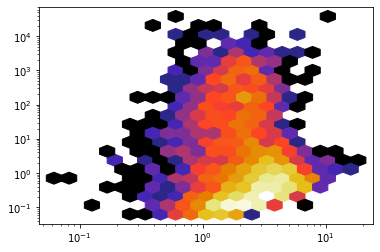

In [62]:
plt.hexbin(np.multiply(np.divide(lyman_values,HI),3.24078e-22),optical_depth,gridsize=20,bins='log',xscale="log",yscale="log",cmap ='CMRmap')

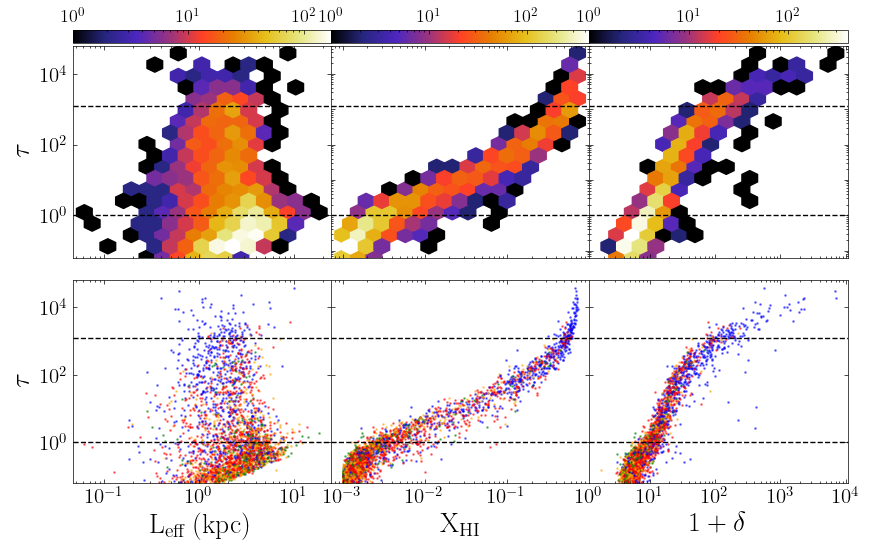

In [56]:
with plt.style.context('science','notebook'):
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(10,6.2),sharex='col' ,gridspec_kw={'height_ratios': [1.25, 1]})
    ax[0][0].set_ylabel(r"$\tau$",fontsize = 20)
    ax[1][0].set_ylabel(r"$\tau$",fontsize = 20)
    data = ax[0][0].hexbin(np.multiply(np.divide(lyman_values,HI),3.24078e-22),optical_depth,gridsize=(15,9),bins='log',xscale="log",yscale="log",cmap ='CMRmap')
    cb1 = plt.colorbar(data,location = "top",pad = 0.01,ax = ax[0][0])
    cb1.ax.tick_params(labelsize=13)
    data2 = ax[0][1].hexbin(neutral_fraction,optical_depth,gridsize=(15,9),bins='log',xscale="log",yscale="log",cmap ='CMRmap')
    cb2 = plt.colorbar(data2,location = "top",pad = 0.01,ax = ax[0][1])
    cb2.ax.tick_params(labelsize=13)
    data3 = ax[0][2].hexbin(np.multiply(gas_den,1.674e-24)/8.69e-28,optical_depth,gridsize=(15,9),bins='log',xscale="log",yscale="log",cmap ='CMRmap')
    cb3 = plt.colorbar(data3,location = "top",pad = 0.01,ax = ax[0][2])
    cb3.ax.tick_params(labelsize=13)
    ax[1][0].set_xlabel("$\mathrm{L_{eff}\:(kpc)}$",fontsize = 20)
    ax[1][1].set_xlabel("$\mathrm{X_{HI}}$",fontsize = 20)
    ax[1][2].set_xlabel("$\mathrm{1+\delta}$",fontsize = 20)
    for i in range(2):
        for j in range(3):
                ax[i][j].set_xscale("log")
                ax[i][j].set_yscale("log")
                ax[i][j].set_ylim(6.3e-18*1e16,6.3e-18*10**22)
                
                ax[i][j].axhline(y=sigma*1.6*10**17,c='black',ls='--')
                ax[i][j].axhline(y=sigma*2*10**20,c='black',ls='--')
                if j != 0:
                    ax[i][j].set_yticklabels([])
                if i != 1:
                    ax[i][j].set_xticklabels([])
                
    for i in range(len(color_difference)):
        if(color_difference[i] == 'blue'):
            ax[1][0].scatter(L_eff[i],optical_depth[i],c= 'blue',s = .8,alpha = .5)
            ax[1][1].scatter(neutral_fraction[i],optical_depth[i],c= 'blue',s = .8,alpha = .5)
            ax[1][2].scatter(delta[i],optical_depth[i],c= 'blue',s = .8,alpha = .5)
        if(color_difference[i] == 'red'):
            ax[1][0].scatter(L_eff[i],optical_depth[i],c= 'red',s = .8,alpha = .5)
            ax[1][1].scatter(neutral_fraction[i],optical_depth[i],c= 'red',s = .8,alpha = .5)
            ax[1][2].scatter(delta[i],optical_depth[i],c= 'red',s = .8,alpha = .5)
        if(color_difference[i] == 'orange'):
            ax[1][0].scatter(L_eff[i],optical_depth[i],c= 'orange',s = .8,alpha = .5)
            ax[1][1].scatter(neutral_fraction[i],optical_depth[i],c= 'orange',s = .8,alpha = .5)
            ax[1][2].scatter(delta[i],optical_depth[i],c= 'orange',s = .8,alpha = .5)
        if(color_difference[i] == 'green'):
            ax[1][0].scatter(L_eff[i],optical_depth[i],c= 'green',s = .8,alpha = .5)
            ax[1][1].scatter(neutral_fraction[i],optical_depth[i],c= 'green',s = .8,alpha = .5)
            ax[1][2].scatter(delta[i],optical_depth[i],c= 'green',s = .8, alpha = .5)
    ax[0][0].tick_params(labelsize=15)
    ax[1][0].tick_params(labelsize=15)
    ax[1][1].tick_params(labelsize=15)
    ax[1][2].tick_params(labelsize=15)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.savefig('f4_final.pdf') 

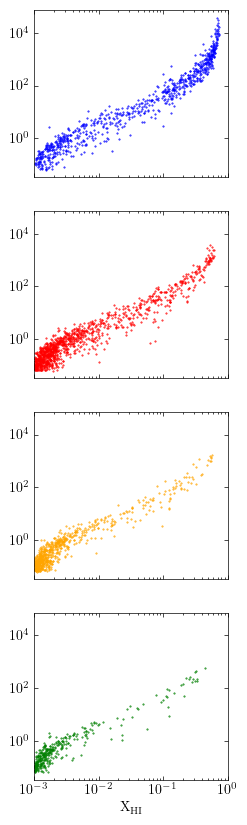

In [19]:
with plt.style.context('science','notebook'):
    fig, ax = plt.subplots(nrows = 4, ncols = 1, sharex=True,sharey=True,figsize=(2.5,10))
    #first it is in cm, HI is number density
    ax[0].scatter(list_2,list_13,s=.2, c = "blue")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].scatter(list_5,list_14,s=.2,c = "red")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[2].scatter(list_8,list_15,s=.2,c = "orange")
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[3].scatter(list_11,list_16,s=.2,c = "green")
    ax[3].set_xlabel("$\mathrm{X_{HI}}$",fontsize = 10)
    ax[3].set_xscale("log")
    ax[3].set_yscale("log")
    ax[3].set_xlim(10**(-3))
    plt.savefig('f4_neutral_fraction.pdf') 

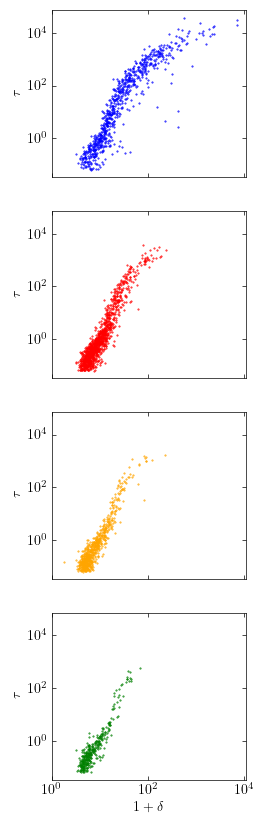

In [20]:
with plt.style.context('science','notebook'):
    fig, ax = plt.subplots(nrows = 4, ncols = 1, sharex=True,sharey=True,figsize=(2.5,10))
    #first it is in cm, HI is number density
    ax[0].scatter(list_3,list_13,s=.2, c = "blue")
    ax[0].set_ylabel(r"$\tau$",fontsize = 10)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].scatter(list_6,list_14,s=.2,c = "red")
    ax[1].set_ylabel(r"$\tau$",fontsize = 10)
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[2].scatter(list_9,list_15,s=.2,c = "orange")
    ax[2].set_ylabel(r"$\tau$",fontsize = 10)
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[3].scatter(list_12,list_16,s=.2,c = "green")
    ax[3].set_xlabel("$\mathrm{1+\delta}$",fontsize = 10)
    ax[3].set_ylabel(r"$\tau$",fontsize = 10)
    ax[3].set_xscale("log")
    ax[3].set_yscale("log")
    plt.xlim(1)
    plt.savefig('f4_1+delta.pdf') 